In [ ]:
!nvidia-smi

Wed Aug 25 06:18:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-TRAIN.csv'
VALID_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-TEST.csv'

IMAGE_PATH_VALID = IMAGE_PATH_TRAIN = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42 # 0,1,2
MODEL_NAME = "UTK-CE_ResNet34_100%-class-97"
PATH = '/content/drive/MyDrive/CSE465/Models_and_Logs/' + MODEL_NAME
GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 256
EPOCHS = 50
learning_rate = 0.0005 #5e-4
NUM_WORKERS = 0
learning_rate_scheduler = False
early_stopping = False
patience = 10

In [ ]:
# GPU or CPU
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')
if early_stopping:
  header.append(f'Patience for Early Stopping: {patience}')
if learning_rate_scheduler:
  header.append(f'Learning Rate Schedule: {learning_rate_scheduler}')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-08-25 12:18:03.769747+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: UTK-CE_ResNet34_100%-class-97
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/UTK-CE_ResNet34_100%-class-97
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 256
Grayscale: False
Learning Rate: 0.0005
Epochs: 50


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [ ]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

Normalizing `torchvision.transforms.Normalize([meanOfC1, meanOfC2, meanOfC3],[stdOfC1, stdOfC2, stdOfC3])`

In [ ]:
custom_transform_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor(),
                                      #transforms.Normalize([0.00058,  0.00047,  0.00042],[0.01957,  0.01619,  0.01502])
                                       ])

In [ ]:
custom_transform_valid = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.CenterCrop((120, 120)),
                                       transforms.ToTensor()])

In [ ]:
train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH_TRAIN,
                               transform=custom_transform_train,
                               items= None
                              )

In [ ]:
valid_dataset = UTKFaceDataset(csv_path=VALID_CSV_PATH,
                               img_dir=IMAGE_PATH_VALID,
                               transform=custom_transform_valid,
                               items=None
                              )

In [ ]:
len(train_dataset), len(valid_dataset)

(18565, 4642)

# Calculatin mean and std to Normalize Dataset Using Standardization

In [ ]:
# loader = DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=1)
# # data = next(iter(tqdm(loader)))
# # data.shape
# for batch in tqdm(loader):
#   print(f'{batch[0][0][0].mean(): .5f}, {batch[0][0][1].mean():.5f}, {batch[0][0][2].mean():.5f}')
#   print(f'{batch[0][0][0].std():.1f}, {batch[0][0][1].std():.1f}, {batch[0][0][2].std():.1f}')
#   # break

In [ ]:
# loader = DataLoader(train_dataset, batch_size = 1000, num_workers=2) # 1000,3,120,120
# total_num_of_pixels = len(train_dataset)*3*120*120
# total_num_of_pixels_in_each_channel = len(train_dataset)*120*120

# print(total_num_of_pixels)
# # print(total_num_of_pixels_in_each_channel*3)
# print(total_num_of_pixels_in_each_channel)

# total_sum_channel1 = total_sum_channel2 = total_sum_channel3 = 0.0
# for batch in tqdm(loader):
#   # total_sum += batch[0].sum()
#   # print(batch[0][0][0].shape)
#   # print(batch[0][0][1].shape)
#   # print(batch[0][0][2].shape)

#   # print(batch[0][0][0])
#   # print(batch[0][0][1])
#   # print(batch[0][0][2])
#   # total_sum +=torch.numel(batch[0])
#   # break
#   total_sum_channel1 +=batch[0][0][0].sum()
#   total_sum_channel2 +=batch[0][0][1].sum()
#   total_sum_channel3 +=batch[0][0][2].sum()

# mean_channel1 = total_sum_channel1/total_num_of_pixels_in_each_channel
# mean_channel2 = total_sum_channel2/total_num_of_pixels_in_each_channel
# mean_channel3 = total_sum_channel3/total_num_of_pixels_in_each_channel
# print(total_sum_channel1, total_sum_channel2, total_sum_channel3)
# print(mean_channel1, mean_channel2, mean_channel3)

# sum_of_squared_error_channel1 = sum_of_squared_error_channel2 = sum_of_squared_error_channel3 = 0
# for batch in tqdm(loader):
#   sum_of_squared_error_channel1 += ((batch[0][0][0] - mean_channel1).pow(2)).sum()
#   sum_of_squared_error_channel2 += ((batch[0][0][1] - mean_channel2).pow(2)).sum()
#   sum_of_squared_error_channel3 += ((batch[0][0][2] - mean_channel3).pow(2)).sum()

# std_channel1= torch.sqrt(sum_of_squared_error_channel1/total_num_of_pixels_in_each_channel)
# std_channel2= torch.sqrt(sum_of_squared_error_channel2/total_num_of_pixels_in_each_channel)
# std_channel3= torch.sqrt(sum_of_squared_error_channel3/total_num_of_pixels_in_each_channel)

# print(sum_of_squared_error_channel1, sum_of_squared_error_channel2, sum_of_squared_error_channel3)
# print(std_channel1, std_channel2, std_channel3)

# finally mean and std for each channels

# print(f'{mean_channel1.item(): .5f}, {mean_channel2.item(): .5f}, {mean_channel3.item(): .5f}')
# print(f'{std_channel1.item(): .1f}, {std_channel2.item(): .1f}, {std_channel3.item(): .1f}')
# # 0.00058,  0.00047,  0.00042
# # 0.01957,  0.01619,  0.01502
# # After applying the above means and stds we get below means and stds what is our desired
# # 0.02948,  0.02864,  0.02780
# # 1.0,  1.0,  1.0a

# Dataset Entity Distribution Analysis

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())  

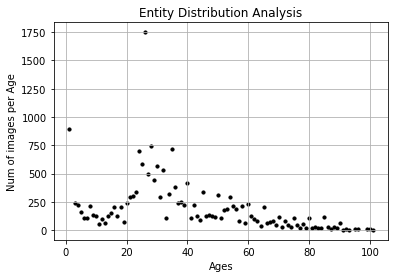

label		Age		Count
0 		 1 		 895
1 		 3 		 241
2 		 4 		 218
3 		 5 		 158
4 		 6 		 105
5 		 7 		 110
6 		 8 		 212
7 		 9 		 138
8 		 10 		 129
9 		 11 		 55
10 		 12 		 102
11 		 13 		 62
12 		 14 		 124
13 		 15 		 152
14 		 16 		 201
15 		 17 		 127
16 		 18 		 202
17 		 19 		 74
18 		 20 		 237
19 		 21 		 291
20 		 22 		 301
21 		 23 		 334
22 		 24 		 696
23 		 25 		 586
24 		 26 		 1749
25 		 27 		 498
26 		 28 		 742
27 		 29 		 444
28 		 30 		 570
29 		 31 		 289
30 		 32 		 533
31 		 33 		 106
32 		 34 		 317
33 		 35 		 721
34 		 36 		 383
35 		 37 		 238
36 		 38 		 250
37 		 39 		 219
38 		 40 		 421
39 		 41 		 109
40 		 42 		 219
41 		 43 		 126
42 		 44 		 86
43 		 45 		 337
44 		 46 		 126
45 		 47 		 137
46 		 48 		 123
47 		 49 		 120
48 		 50 		 315
49 		 51 		 110
50 		 52 		 175
51 		 53 		 189
52 		 54 		 290
53 		 55 		 213
54 		 56 		 186
55 		 57 		 81
56 		 58 		 210
57 		 59 		 65
58 		 60 		 231
59 		 61 		 126
60 		 62 		 100
61 		 63 		 85
62 		 64 		 36

In [ ]:
dataset_analysis(train_dataset)

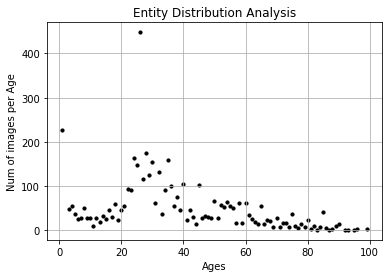

label		Age		Count
0 		 1 		 228
1 		 3 		 48
2 		 4 		 55
3 		 5 		 38
4 		 6 		 26
5 		 7 		 29
6 		 8 		 51
7 		 9 		 28
8 		 10 		 27
9 		 11 		 10
10 		 12 		 28
11 		 13 		 19
12 		 14 		 33
13 		 15 		 25
14 		 16 		 46
15 		 17 		 31
16 		 18 		 60
17 		 19 		 24
18 		 20 		 47
19 		 21 		 55
20 		 22 		 94
21 		 23 		 92
22 		 24 		 163
23 		 25 		 148
24 		 26 		 448
25 		 27 		 117
26 		 28 		 176
27 		 29 		 126
28 		 30 		 154
29 		 31 		 61
30 		 32 		 131
31 		 33 		 37
32 		 34 		 92
33 		 35 		 159
34 		 36 		 100
35 		 37 		 55
36 		 38 		 75
37 		 39 		 47
38 		 40 		 105
39 		 41 		 23
40 		 42 		 47
41 		 43 		 31
42 		 44 		 14
43 		 45 		 103
44 		 46 		 27
45 		 47 		 33
46 		 48 		 30
47 		 49 		 28
48 		 50 		 66
49 		 51 		 28
50 		 52 		 57
51 		 53 		 52
52 		 54 		 63
53 		 55 		 55
54 		 56 		 50
55 		 57 		 16
56 		 58 		 61
57 		 59 		 17
58 		 60 		 62
59 		 61 		 35
60 		 62 		 25
61 		 63 		 18
62 		 64 		 14
63 		 65 		 54
64 		 66 		 15
65 		 67 		 

In [ ]:
dataset_analysis(valid_dataset)

# Dataset spliting into train and valid set

In [ ]:
# valid_size = round(len(train_dataset)*20*0.01) # 20% from train_dataset
# train_size = len(train_dataset)-valid_size
# print(train_size, valid_size)

# train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

In [ ]:
# type(list(train_dataset)),type(valid_dataset),type(test_dataset)
# test_dataset.y
# train_dataset.dataset.y
# valid_dataset.dataset.y

In [ ]:
len(train_dataset),len(valid_dataset)

(18565, 4642)

# Dataset Loader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [ ]:
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False, # False
                          num_workers=NUM_WORKERS)

In [ ]:
len(train_loader),len(valid_loader)

(73, 19)

In [ ]:
# sample1 = next(iter(train_loader))
# features1, labels1 = sample1
# sample2 = next(iter(valid_loader))
# features2, labels2 = sample2

In [ ]:
# features1.shape, features2.shape

# Model

### ResNet34

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

`nn.RELU(inplace=True)` [details](https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948)

Understanding the underscore( _ ) of Python [link](https://stackoverflow.com/questions/8689964/why-do-some-functions-have-underscores-before-and-after-the-function-name)

`self.modules()` [link](https://discuss.pytorch.org/t/pytorch-self-module/49677)

What do `*` and `**` before a variable name mean in a function signature? [link](https://stackoverflow.com/questions/11315010/what-do-and-before-a-variable-name-mean-in-a-function-signature)

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = x.view(x.size(0), -1) # reshaping, -1 means calculate the suitable number for second dimension 
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [ ]:
# lol = torch.tensor([[.3,.35,.35],
#                        [.3,.35,.35]], dtype=float)
# probas = F.softmax(lol, dim=1)
# _, predicted_labels = torch.max(probas, dim=1)
# predicted_labels = probas > 0.5
# num_correct_preds = torch.sum(predicted_labels == targets)
# total_num_correct_preds += num_correct_preds
# num_examples += targets.size(0)
# mae += torch.sum(torch.abs(predicted_labels - targets))
# print(probas)
# print(predicted_labels)

### VGG/DEX

In [ ]:
def vgg_block(in_channels, out_channels, more=False):
    blocklist = [
        ('conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)),
        ('relu1', nn.ReLU(inplace=True)),
        ('conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),
        ('relu2', nn.ReLU(inplace=True)),
    ]
    if more:
        blocklist.extend([
            ('conv3', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),
            ('relu3', nn.ReLU(inplace=True)),
        ])
    blocklist.append(('maxpool', nn.MaxPool2d(kernel_size=2, stride=2)))
    block = nn.Sequential(OrderedDict(blocklist))
    return block

# VGG16 architecture
class VGG(nn.Module):
    def __init__(self, classes=40, channels=3):
        super().__init__()
        self.conv = nn.Sequential(
            vgg_block(channels, 64),
            vgg_block(64, 128),
            vgg_block(128, 256, True),
            vgg_block(256, 512, True),
            vgg_block(512, 512, True),
        )
        self.fc1 = nn.Sequential(
            # nn.Linear(512*7*7, 4096),
            nn.Linear(512*4*4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5, inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5, inplace=True),
        )
        self.cls = nn.Linear(4096, classes)

    def forward(self, x):
        in_size = x.shape[0]
        x = self.conv(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.cls(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

class Gender(VGG):
    def __init__(self, classes=2, channels=3):
        super().__init__()
        self.cls = nn.Linear(4096, classes)

class VGG_Age(VGG):
    def __init__(self, classes=40, channels=3):
        super().__init__()
        self.cls = nn.Linear(4096, classes)

# Initialise Model & Optimizer

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES, GRAYSCALE)

# model = VGG_Age()
# model = models.resnet50(progress= True, num_classes=21)
# model.load_state_dict(checkpoint)

model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if learning_rate_scheduler:
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# ar = torch.rand([2,3,224,224])

In [ ]:
# a = model(ar)

# a[0].shape, a[1].shape, a

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
# samples = next(iter(train_loader))

In [ ]:
# len(samples) # 2
# features = samples[0] # torch.Size([256, 3, 120, 120]),
# targets = samples[1]  # torch.Size([256])
# targets.shape

In [ ]:
min_valid_mae = np.inf
previous_valid_mae = np.inf
start_time = time.time()
best_model_wts = copy.deepcopy(model.state_dict())

epochs_no_improve = 0
for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = valid_total_num_correct_preds = train_num_examples = valid_num_examples = 0.0
 
  model.train()
  train_mae=0.0
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):
      targets, features =  targets.to(DEVICE), features.to(DEVICE)

      # FORWARD AND BACK PROP
      logits, probas = model(features)
      cost = F.cross_entropy(logits, targets)
      _, predicted_labels = torch.max(probas, dim=1)
      optimizer.zero_grad()
      cost.backward()

      # UPDATE MODEL PARAMETERS
      optimizer.step()
      # UPDATE LEARNING RATE
      if learning_rate_scheduler:
        scheduler.step()
      
      train_total_num_correct_preds += calculate_correct_preds(probas, targets)
      train_num_examples += targets.size(0) 
      train_mae += torch.sum(torch.abs(predicted_labels - targets))

  train_mae = train_mae/train_num_examples

  model.eval()
  valid_mae = 0.0
  for i, (features, targets) in enumerate(tqdm(valid_loader)):
      targets, features =  targets.to(DEVICE), features.to(DEVICE)

      logits, probas = model(features)
      cost_valid = F.cross_entropy(logits, targets)
      _, predicted_labels = torch.max(probas, dim=1)

      valid_total_num_correct_preds += calculate_correct_preds(probas, targets)
      valid_num_examples += targets.size(0)
      valid_mae += torch.sum(torch.abs(predicted_labels - targets))

  valid_mae = valid_mae/valid_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds} | Correct Valid Preds: {valid_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)
  valid_acc = compute_acc(valid_total_num_correct_preds, valid_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  # str1 = f'Epoch: {epoch+1}/{EPOCHS} | Training MAE: {format(train_mae, ".3f")} | Training_Acc: {training_acc}% | Training_Cost: {format(cost, ".3f")} ' 
  # str2 = f'| Validation MAE: {format(valid_mae, ".3f")} | Validation_Acc: {valid_acc}% | Validation Cost: {format(cost_valid, ".3f")} \n Time elapsed: {time_elapsed}mins'
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}   | Validation MAE: {format(valid_mae, ".3f")} \n'
  str4 = f'Training_Cost: {format(cost, ".3f")}  | Validation Cost: {format(cost_valid, ".3f")} \n'
  str5 = f'Training_Acc: {training_acc}% | Validation_Acc: {valid_acc}% \n'
  str6 = f'Time elapsed: {time_elapsed}mins \n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

  if valid_mae<previous_valid_mae:
    epochs_no_improve=0
    previous_valid_mae = valid_mae

  if valid_mae < min_valid_mae:
    str = f'Validation MAE Decreased({format(min_valid_mae, ".3f")}--->{format(valid_mae, ".3f")}) ---Copying State Dict---\n'
    print(str)
    with open(LOGFILE, 'a') as f: f.write(f'{str}')
    min_valid_mae = valid_mae
    best_model_wts = copy.deepcopy(model.state_dict())
  else:
    if early_stopping:
      epochs_no_improve+=1

  if early_stopping:
    if epochs_no_improve == patience:
      print("EARLY STOPPING CALLED! \n")
      with open(LOGFILE, 'a') as f: f.write('############-------Early Stopping Called-------############')
      break
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 2343.0 | Correct Valid Preds: 631.0
Epoch: 1/50 
--------------------------------------------------------------------
Training MAE: 13.309   | Validation MAE: 10.344 
Training_Cost: 3.581  | Validation Cost: 3.345 
Training_Acc: 12.621% | Validation_Acc: 13.593% 
Time elapsed: 99.639mins 

Validation MAE Decreased(inf--->10.344) ---Copying State Dict---



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 2746.0 | Correct Valid Preds: 709.0
Epoch: 2/50 
--------------------------------------------------------------------
Training MAE: 8.928   | Validation MAE: 10.695 
Training_Cost: 3.380  | Validation Cost: 3.307 
Training_Acc: 14.791% | Validation_Acc: 15.274% 
Time elapsed: 101.192mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 2960.0 | Correct Valid Preds: 710.0
Epoch: 3/50 
--------------------------------------------------------------------
Training MAE: 7.744   | Validation MAE: 9.396 
Training_Cost: 3.246  | Validation Cost: 3.289 
Training_Acc: 15.944% | Validation_Acc: 15.295% 
Time elapsed: 102.738mins 

Validation MAE Decreased(10.344--->9.396) ---Copying State Dict---



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 3199.0 | Correct Valid Preds: 795.0
Epoch: 4/50 
--------------------------------------------------------------------
Training MAE: 7.004   | Validation MAE: 7.312 
Training_Cost: 3.242  | Validation Cost: 3.017 
Training_Acc: 17.231% | Validation_Acc: 17.126% 
Time elapsed: 104.275mins 

Validation MAE Decreased(9.396--->7.312) ---Copying State Dict---



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 3408.0 | Correct Valid Preds: 823.0
Epoch: 5/50 
--------------------------------------------------------------------
Training MAE: 6.492   | Validation MAE: 7.078 
Training_Cost: 3.060  | Validation Cost: 3.054 
Training_Acc: 18.357% | Validation_Acc: 17.729% 
Time elapsed: 105.811mins 

Validation MAE Decreased(7.312--->7.078) ---Copying State Dict---



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 3450.0 | Correct Valid Preds: 751.0
Epoch: 6/50 
--------------------------------------------------------------------
Training MAE: 6.089   | Validation MAE: 6.494 
Training_Cost: 2.960  | Validation Cost: 3.163 
Training_Acc: 18.583% | Validation_Acc: 16.178% 
Time elapsed: 107.346mins 

Validation MAE Decreased(7.078--->6.494) ---Copying State Dict---



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 3664.0 | Correct Valid Preds: 746.0
Epoch: 7/50 
--------------------------------------------------------------------
Training MAE: 5.766   | Validation MAE: 6.993 
Training_Cost: 3.044  | Validation Cost: 3.099 
Training_Acc: 19.736% | Validation_Acc: 16.071% 
Time elapsed: 108.890mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 3854.0 | Correct Valid Preds: 534.0
Epoch: 8/50 
--------------------------------------------------------------------
Training MAE: 5.525   | Validation MAE: 10.361 
Training_Cost: 2.868  | Validation Cost: 3.713 
Training_Acc: 20.759% | Validation_Acc: 11.504% 
Time elapsed: 110.420mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 4073.0 | Correct Valid Preds: 633.0
Epoch: 9/50 
--------------------------------------------------------------------
Training MAE: 5.297   | Validation MAE: 7.897 
Training_Cost: 2.877  | Validation Cost: 3.398 
Training_Acc: 21.939% | Validation_Acc: 13.636% 
Time elapsed: 111.949mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 4352.0 | Correct Valid Preds: 642.0
Epoch: 10/50 
--------------------------------------------------------------------
Training MAE: 5.076   | Validation MAE: 7.986 
Training_Cost: 2.743  | Validation Cost: 3.205 
Training_Acc: 23.442% | Validation_Acc: 13.830% 
Time elapsed: 113.497mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 4560.0 | Correct Valid Preds: 625.0
Epoch: 11/50 
--------------------------------------------------------------------
Training MAE: 4.847   | Validation MAE: 9.020 
Training_Cost: 2.720  | Validation Cost: 3.982 
Training_Acc: 24.562% | Validation_Acc: 13.464% 
Time elapsed: 115.031mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 5019.0 | Correct Valid Preds: 753.0
Epoch: 12/50 
--------------------------------------------------------------------
Training MAE: 4.566   | Validation MAE: 6.966 
Training_Cost: 2.765  | Validation Cost: 3.391 
Training_Acc: 27.035% | Validation_Acc: 16.221% 
Time elapsed: 116.567mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 5498.0 | Correct Valid Preds: 660.0
Epoch: 13/50 
--------------------------------------------------------------------
Training MAE: 4.327   | Validation MAE: 8.303 
Training_Cost: 2.536  | Validation Cost: 3.516 
Training_Acc: 29.615% | Validation_Acc: 14.218% 
Time elapsed: 118.109mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 6163.0 | Correct Valid Preds: 450.0
Epoch: 14/50 
--------------------------------------------------------------------
Training MAE: 4.030   | Validation MAE: 11.630 
Training_Cost: 2.534  | Validation Cost: 4.425 
Training_Acc: 33.197% | Validation_Acc: 9.694% 
Time elapsed: 119.647mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 6885.0 | Correct Valid Preds: 756.0
Epoch: 15/50 
--------------------------------------------------------------------
Training MAE: 3.837   | Validation MAE: 6.765 
Training_Cost: 2.277  | Validation Cost: 3.639 
Training_Acc: 37.086% | Validation_Acc: 16.286% 
Time elapsed: 121.181mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 7739.0 | Correct Valid Preds: 390.0
Epoch: 16/50 
--------------------------------------------------------------------
Training MAE: 3.519   | Validation MAE: 11.240 
Training_Cost: 2.104  | Validation Cost: 4.355 
Training_Acc: 41.686% | Validation_Acc: 8.402% 
Time elapsed: 122.715mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 8849.0 | Correct Valid Preds: 642.0
Epoch: 17/50 
--------------------------------------------------------------------
Training MAE: 3.143   | Validation MAE: 6.786 
Training_Cost: 2.037  | Validation Cost: 3.966 
Training_Acc: 47.665% | Validation_Acc: 13.830% 
Time elapsed: 124.268mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 10091.0 | Correct Valid Preds: 600.0
Epoch: 18/50 
--------------------------------------------------------------------
Training MAE: 2.745   | Validation MAE: 9.140 
Training_Cost: 1.920  | Validation Cost: 4.681 
Training_Acc: 54.355% | Validation_Acc: 12.925% 
Time elapsed: 125.817mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 11265.0 | Correct Valid Preds: 622.0
Epoch: 19/50 
--------------------------------------------------------------------
Training MAE: 2.379   | Validation MAE: 7.117 
Training_Cost: 1.530  | Validation Cost: 4.248 
Training_Acc: 60.679% | Validation_Acc: 13.399% 
Time elapsed: 127.358mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 12417.0 | Correct Valid Preds: 567.0
Epoch: 20/50 
--------------------------------------------------------------------
Training MAE: 2.039   | Validation MAE: 7.558 
Training_Cost: 1.243  | Validation Cost: 4.438 
Training_Acc: 66.884% | Validation_Acc: 12.215% 
Time elapsed: 128.921mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 13638.0 | Correct Valid Preds: 347.0
Epoch: 21/50 
--------------------------------------------------------------------
Training MAE: 1.664   | Validation MAE: 12.301 
Training_Cost: 1.187  | Validation Cost: 5.589 
Training_Acc: 73.461% | Validation_Acc: 7.475% 
Time elapsed: 130.453mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 14386.0 | Correct Valid Preds: 445.0
Epoch: 22/50 
--------------------------------------------------------------------
Training MAE: 1.407   | Validation MAE: 7.874 
Training_Cost: 0.847  | Validation Cost: 6.049 
Training_Acc: 77.490% | Validation_Acc: 9.586% 
Time elapsed: 131.988mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 15086.0 | Correct Valid Preds: 755.0
Epoch: 23/50 
--------------------------------------------------------------------
Training MAE: 1.181   | Validation MAE: 7.079 
Training_Cost: 0.936  | Validation Cost: 5.255 
Training_Acc: 81.260% | Validation_Acc: 16.265% 
Time elapsed: 133.528mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 15751.0 | Correct Valid Preds: 608.0
Epoch: 24/50 
--------------------------------------------------------------------
Training MAE: 0.944   | Validation MAE: 8.095 
Training_Cost: 0.631  | Validation Cost: 5.701 
Training_Acc: 84.842% | Validation_Acc: 13.098% 
Time elapsed: 135.060mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 16131.0 | Correct Valid Preds: 608.0
Epoch: 25/50 
--------------------------------------------------------------------
Training MAE: 0.846   | Validation MAE: 6.945 
Training_Cost: 0.628  | Validation Cost: 5.393 
Training_Acc: 86.889% | Validation_Acc: 13.098% 
Time elapsed: 136.592mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 16512.0 | Correct Valid Preds: 684.0
Epoch: 26/50 
--------------------------------------------------------------------
Training MAE: 0.704   | Validation MAE: 6.955 
Training_Cost: 0.487  | Validation Cost: 5.976 
Training_Acc: 88.942% | Validation_Acc: 14.735% 
Time elapsed: 138.134mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 16709.0 | Correct Valid Preds: 582.0
Epoch: 27/50 
--------------------------------------------------------------------
Training MAE: 0.633   | Validation MAE: 7.724 
Training_Cost: 0.836  | Validation Cost: 5.284 
Training_Acc: 90.003% | Validation_Acc: 12.538% 
Time elapsed: 139.668mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 16970.0 | Correct Valid Preds: 678.0
Epoch: 28/50 
--------------------------------------------------------------------
Training MAE: 0.559   | Validation MAE: 7.701 
Training_Cost: 0.380  | Validation Cost: 5.316 
Training_Acc: 91.409% | Validation_Acc: 14.606% 
Time elapsed: 141.205mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17117.0 | Correct Valid Preds: 632.0
Epoch: 29/50 
--------------------------------------------------------------------
Training MAE: 0.544   | Validation MAE: 7.988 
Training_Cost: 0.409  | Validation Cost: 5.633 
Training_Acc: 92.200% | Validation_Acc: 13.615% 
Time elapsed: 142.751mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17322.0 | Correct Valid Preds: 671.0
Epoch: 30/50 
--------------------------------------------------------------------
Training MAE: 0.435   | Validation MAE: 7.912 
Training_Cost: 0.401  | Validation Cost: 6.005 
Training_Acc: 93.305% | Validation_Acc: 14.455% 
Time elapsed: 144.304mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17435.0 | Correct Valid Preds: 696.0
Epoch: 31/50 
--------------------------------------------------------------------
Training MAE: 0.387   | Validation MAE: 6.936 
Training_Cost: 0.271  | Validation Cost: 5.641 
Training_Acc: 93.913% | Validation_Acc: 14.994% 
Time elapsed: 145.854mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17439.0 | Correct Valid Preds: 631.0
Epoch: 32/50 
--------------------------------------------------------------------
Training MAE: 0.422   | Validation MAE: 6.924 
Training_Cost: 0.339  | Validation Cost: 5.417 
Training_Acc: 93.935% | Validation_Acc: 13.593% 
Time elapsed: 147.409mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17511.0 | Correct Valid Preds: 544.0
Epoch: 33/50 
--------------------------------------------------------------------
Training MAE: 0.379   | Validation MAE: 9.915 
Training_Cost: 0.198  | Validation Cost: 5.914 
Training_Acc: 94.323% | Validation_Acc: 11.719% 
Time elapsed: 148.950mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17568.0 | Correct Valid Preds: 683.0
Epoch: 34/50 
--------------------------------------------------------------------
Training MAE: 0.335   | Validation MAE: 7.046 
Training_Cost: 0.216  | Validation Cost: 5.929 
Training_Acc: 94.630% | Validation_Acc: 14.713% 
Time elapsed: 150.487mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17693.0 | Correct Valid Preds: 524.0
Epoch: 35/50 
--------------------------------------------------------------------
Training MAE: 0.312   | Validation MAE: 10.614 
Training_Cost: 0.246  | Validation Cost: 6.309 
Training_Acc: 95.303% | Validation_Acc: 11.288% 
Time elapsed: 152.020mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17669.0 | Correct Valid Preds: 691.0
Epoch: 36/50 
--------------------------------------------------------------------
Training MAE: 0.328   | Validation MAE: 7.308 
Training_Cost: 0.266  | Validation Cost: 6.210 
Training_Acc: 95.174% | Validation_Acc: 14.886% 
Time elapsed: 153.572mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17696.0 | Correct Valid Preds: 661.0
Epoch: 37/50 
--------------------------------------------------------------------
Training MAE: 0.308   | Validation MAE: 6.937 
Training_Cost: 0.231  | Validation Cost: 5.911 
Training_Acc: 95.319% | Validation_Acc: 14.240% 
Time elapsed: 155.116mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17655.0 | Correct Valid Preds: 706.0
Epoch: 38/50 
--------------------------------------------------------------------
Training MAE: 0.322   | Validation MAE: 7.436 
Training_Cost: 0.187  | Validation Cost: 6.144 
Training_Acc: 95.098% | Validation_Acc: 15.209% 
Time elapsed: 156.653mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17677.0 | Correct Valid Preds: 720.0
Epoch: 39/50 
--------------------------------------------------------------------
Training MAE: 0.312   | Validation MAE: 7.024 
Training_Cost: 0.221  | Validation Cost: 5.972 
Training_Acc: 95.217% | Validation_Acc: 15.511% 
Time elapsed: 158.189mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17627.0 | Correct Valid Preds: 600.0
Epoch: 40/50 
--------------------------------------------------------------------
Training MAE: 0.336   | Validation MAE: 7.217 
Training_Cost: 0.241  | Validation Cost: 5.251 
Training_Acc: 94.947% | Validation_Acc: 12.925% 
Time elapsed: 159.732mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17618.0 | Correct Valid Preds: 651.0
Epoch: 41/50 
--------------------------------------------------------------------
Training MAE: 0.332   | Validation MAE: 7.197 
Training_Cost: 0.188  | Validation Cost: 5.760 
Training_Acc: 94.899% | Validation_Acc: 14.024% 
Time elapsed: 161.265mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17642.0 | Correct Valid Preds: 651.0
Epoch: 42/50 
--------------------------------------------------------------------
Training MAE: 0.335   | Validation MAE: 7.120 
Training_Cost: 0.148  | Validation Cost: 6.323 
Training_Acc: 95.028% | Validation_Acc: 14.024% 
Time elapsed: 162.796mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17646.0 | Correct Valid Preds: 623.0
Epoch: 43/50 
--------------------------------------------------------------------
Training MAE: 0.328   | Validation MAE: 7.243 
Training_Cost: 0.258  | Validation Cost: 6.385 
Training_Acc: 95.050% | Validation_Acc: 13.421% 
Time elapsed: 164.328mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17674.0 | Correct Valid Preds: 529.0
Epoch: 44/50 
--------------------------------------------------------------------
Training MAE: 0.327   | Validation MAE: 9.762 
Training_Cost: 0.231  | Validation Cost: 6.003 
Training_Acc: 95.201% | Validation_Acc: 11.396% 
Time elapsed: 165.866mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17639.0 | Correct Valid Preds: 657.0
Epoch: 45/50 
--------------------------------------------------------------------
Training MAE: 0.338   | Validation MAE: 7.106 
Training_Cost: 0.280  | Validation Cost: 5.089 
Training_Acc: 95.012% | Validation_Acc: 14.153% 
Time elapsed: 167.398mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17631.0 | Correct Valid Preds: 632.0
Epoch: 46/50 
--------------------------------------------------------------------
Training MAE: 0.348   | Validation MAE: 7.432 
Training_Cost: 0.136  | Validation Cost: 6.309 
Training_Acc: 94.969% | Validation_Acc: 13.615% 
Time elapsed: 168.934mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17578.0 | Correct Valid Preds: 607.0
Epoch: 47/50 
--------------------------------------------------------------------
Training MAE: 0.347   | Validation MAE: 7.544 
Training_Cost: 0.157  | Validation Cost: 5.478 
Training_Acc: 94.684% | Validation_Acc: 13.076% 
Time elapsed: 170.469mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17616.0 | Correct Valid Preds: 658.0
Epoch: 48/50 
--------------------------------------------------------------------
Training MAE: 0.347   | Validation MAE: 7.159 
Training_Cost: 0.208  | Validation Cost: 6.069 
Training_Acc: 94.888% | Validation_Acc: 14.175% 
Time elapsed: 172.000mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17614.0 | Correct Valid Preds: 679.0
Epoch: 49/50 
--------------------------------------------------------------------
Training MAE: 0.348   | Validation MAE: 7.195 
Training_Cost: 0.145  | Validation Cost: 6.653 
Training_Acc: 94.877% | Validation_Acc: 14.627% 
Time elapsed: 173.541mins 



  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Correct Train Preds: 17604.0 | Correct Valid Preds: 621.0
Epoch: 50/50 
--------------------------------------------------------------------
Training MAE: 0.370   | Validation MAE: 7.631 
Training_Cost: 0.215  | Validation Cost: 6.505 
Training_Acc: 94.824% | Validation_Acc: 13.378% 
Time elapsed: 175.086mins 

TRAINING COMPLETED


# Evaluation

In [ ]:
# b = [0.2, 0.2, 0.2, 0.1, 0.2]
# b = np.array(b)

# a = b>0.5
# a

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)
    
    _, predicted_labels = torch.max(probas, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.load_state_dict(best_model_wts)
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)

  valid_mae, valid_mse, valid_acc = compute_mae_and_mse(model, valid_loader, device=DEVICE)

  str1 = f'Training MAE: {train_mae}   | Validation MAE: {valid_mae} \n'
  str2 = f'Training RMSE: {train_mse}  | Validation RMSE: {valid_mse} \n'
  str3 = f'Training Acc: {train_acc}% | Validation Acc: {valid_acc}% \n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 3680
total_num_correct_preds: 751
Training MAE: 5.802   | Validation MAE: 6.494 
Training RMSE: 9.014  | Validation RMSE: 9.636 
Training Acc: 19.822% | Validation Acc: 16.178% 

Total Elapsed Time: 176.244 mins 



# Saving the Model

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [ ]:
model = model.to(torch.device('cpu'))
torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))